In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import geopandas
import matplotlib
import scipy.stats as st

from utils import *
from viz import *
from decision_functions import *
from metrics import *
import seaborn as sns
import os

from sklearn.calibration import CalibrationDisplay


%matplotlib inline

## Parameters

In [2]:
fidelity_metric = "L1"
DATA_FILE = "data/df_agg_nc2020_dataverse.pkl"
SHAPEFILE = "data/cb_2022_us_county_500k/cb_2022_us_county_500k.shp"

### Save plots, predictions (good for large data samples)
save = False

## Data Details

In [3]:
## Data Source Info
UNCODED_VAL = 6
WHITE_VAL = 4

race_labels = [
    "nh_aian",
    "nh_api",
    "nh_black",
    "hispanic",
    "nh_white",
    "other",
]

display_order = [
    "Black",
    "Hispanic",
    "API",
    "AIAN",
    "White",
    "Other",
]

variable_codes = {race: number for number, race in enumerate(race_labels)}

race_text = pd.Series(
    [
        "AIAN",
        "API",
        "Black",
        "Hispanic",
        "White",
        "Other",
        "Uncoded",
    ],
    name="Race",
)

display_reordering = [2, 3, 1, 0, 4, 5, 6]


model_types = ["bisg", "rake", "bisg_cen"]


def get_prob_cols(model_type):
    match model_type:
        case "bisg":
            prob_cols = [f"bisg_bayes_{race}" for race in race_labels]
        case "rake":
            prob_cols = [f"rake_{race}" for race in race_labels]
        case "bisg_cen":
            prob_cols = [f"bisg_cen_county_{race}" for race in race_labels]
    return prob_cols


true_vf_labels = [f"vf_{race}" for race in race_labels]

In [4]:
all_prob_cols = [col for model_type in model_types for col in get_prob_cols(model_type)]
print(all_prob_cols)

['bisg_bayes_nh_aian', 'bisg_bayes_nh_api', 'bisg_bayes_nh_black', 'bisg_bayes_hispanic', 'bisg_bayes_nh_white', 'bisg_bayes_other', 'rake_nh_aian', 'rake_nh_api', 'rake_nh_black', 'rake_hispanic', 'rake_nh_white', 'rake_other', 'bisg_cen_county_nh_aian', 'bisg_cen_county_nh_api', 'bisg_cen_county_nh_black', 'bisg_cen_county_hispanic', 'bisg_cen_county_nh_white', 'bisg_cen_county_other']


## Cleaning & Processing

In [6]:
## cleaning


def clean_data(state_voter_file, prob_cols, condition_cols=None):
    """
    if truncate is an int, make the data (and all subsets) divisible by that int.
    """
    condition_cols = [] if condition_cols is None else condition_cols
    true_labels = state_voter_file[true_vf_labels].astype(int)
    long_labels = (
        true_labels.apply(
            lambda row: np.repeat(list(range(len(race_labels))), row), axis=1
        )
        .explode()
        .reset_index(drop=True)
        .astype(int)
    )

    probs = state_voter_file[prob_cols].astype(float)
    assert np.isclose(np.sum(probs, axis=1), 1).all()
    duplications = true_labels.sum(axis=1)
    probs = pd.DataFrame(np.repeat(probs, duplications, axis=0), columns=probs.columns)

    cleaned = probs
    cleaned["true"] = long_labels
    cleaned[condition_cols] = pd.DataFrame(
        np.repeat(state_voter_file[condition_cols], duplications, axis=0),
        columns=condition_cols,
    )
    cleaned = cleaned.sample(frac=1)

    return cleaned


state_voter_file = pd.read_pickle(DATA_FILE)  ## no need to repeat this

In [7]:
## DATA PARAMETERS
state = "NC"
model_type = "bisg"

prob_cols = get_prob_cols(model_type)

condition_columns = None  # ["county"]
condtext = "" if condition_columns is None else f"_{condition_columns}conds"

predictions_dir = f"predictions/{state}/{model_type}/"
plots_dir = f"plots/{state}/{model_type}/"
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(predictions_dir, exist_ok=True)

## Discretizations

In [8]:
## DISCRETIZATION PARAMETERS
USE_METHODS = {
    "Argmax",
    "Thompson Sampling",
    "Aggregate Posterior Matching",
    "Threshold",
    "Data-Driven Threshold",
    # "Integer Program", ## COMMENTED OUT BY DEFAULT. WILL ONLY WORK WITH GUROBI LICENSE OR OTHER INTEGER PROGRAM SOLVER INSTALLED.
    "Nucleus Sampling",
    "True Population Matching",
}

## integer program gamma values
gammas = np.round(np.linspace(0.8, 0.99, 20, endpoint=True), 2)
## thresholds
thresholds = np.round(np.linspace(0.5, 1, 11, endpoint=True), 2)
## nucleus Ks
nucleus_ks = np.arange(2, len(prob_cols))


## batching & calculations
N = 100000  ## default None is the whole dataset
batch_size = 5000
n_processes = (
    0  ## 0 indicates is heuristic for what's fastest; 1 is not multiprocessed.
)
remainder = False  ## By default, splits batches for joint decision-making into (approximately) evenly sized batches as close to the batch size as possible. If True, calculates as exact sizes, with a single batch of the remaining data pionts.

In [9]:
# CLEAN DATA
cleaned = clean_data(state_voter_file, prob_cols, condition_cols=condition_columns)
if N is not None:
    cleaned = cleaned.iloc[:N]
labels = cleaned["true"]
probs = cleaned[prob_cols]
n_prob_classes = len(prob_cols)

In [10]:
## INDIVIDUAL DISCRETIZATIONS
predictions = pd.DataFrame(index=probs.index)

predictions["true"] = labels
predictions.columns.name = "Method"

if "Argmax" in USE_METHODS:
    predictions["Argmax"] = mode_discretization(probs)

if "Thompson Sampling" in USE_METHODS:
    predictions["Thompson Sampling"] = thompson_discretization(probs)

# PARTIAL THRESHOLDS
if "Threshold" in USE_METHODS:
    thresholded_preds = pd.DataFrame(
        {
            f"Threshold at {threshold}": prelim_threshold(
                probs, threshold, uncoded_val=UNCODED_VAL
            )
            for threshold in thresholds
        }
    )  # , index=probs)
    predictions = predictions.join([thresholded_preds], validate="one_to_one")

# NUCLEUS SAMPLES
if "Nucleus Sampling" in USE_METHODS:
    nucleus_preds = pd.DataFrame(
        {
            f"Top-{k} Nucleus Sampling": nucleus_sampling(probs, top_k=k)
            for k in range(2, probs.shape[1])
        },
        index=probs.index,
    )
    predictions = predictions.join([nucleus_preds], validate="one_to_one")
# predictions = predictions.join([matching_preds, thresholded_preds, nucleus_preds, ip_preds], validate="one_to_one")

In [11]:
## JOINT DISCRETIZATIONS

batches, true_marginals = conditional_batching(
    cleaned,
    batch_size,
    condition_columns,
    prob_cols,
    marginal_label_col="true",
    remainder=remainder,
)

if "Aggregate Posterior Matching" in USE_METHODS:
    aggregate_posterior_max_weight = batched_max_weight(batches, reference_dists=None)
    aggregate_posterior_max_weight.name = "Aggregate Posterior Matching"
    predictions = predictions.join(
        [aggregate_posterior_max_weight], validate="one_to_one"
    )

if "True Population Matching" in USE_METHODS:
    true_marginal_max_weight = batched_max_weight(
        batches, reference_dists=true_marginals
    )
    true_marginal_max_weight.name = "True Population Matching"
    predictions = predictions.join([true_marginal_max_weight], validate="one_to_one")

if "Integer Program" in USE_METHODS:
    raw_ips = batched_integer_program(batches, gammas, fidelity_metric)
    ip_preds = pd.DataFrame(
        {
            f"Integer Program, $\gamma = {gamma}$": ip_pred
            for gamma, ip_pred in zip(gammas, raw_ips)
        }
    )
    predictions = predictions.join([ip_preds], validate="one_to_one")

conditional value all
condition size 100000


/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


max counts allocated per class max counts allocated per class bisg_bayes_nh_aian       84
bisg_bayes_nh_api        89
bisg_bayes_nh_black    1042
bisg_bayes_hispanic     193
bisg_bayes_nh_white    3566
bisg_bayes_other         26
dtype: int64
bisg_bayes_nh_aian       89
bisg_bayes_nh_api       102
bisg_bayes_nh_black    1050
bisg_bayes_hispanic     176
bisg_bayes_nh_white    3557
bisg_bayes_other         26
dtype: int64
max counts allocated per class bisg_bayes_nh_aian       91
bisg_bayes_nh_api       104
bisg_bayes_nh_black    1042
bisg_bayes_hispanic     182
bisg_bayes_nh_white    3555
bisg_bayes_other         26
dtype: int64
max counts allocated per class bisg_bayes_nh_aian       81
bisg_bayes_nh_api        82
bisg_bayes_nh_black    1038
bisg_bayes_hispanic     183
bisg_bayes_nh_white    3590
bisg_bayes_other         26
dtype: int64
max counts allocated per class bisg_bayes_nh_aian       85
bisg_bayes_nh_api       114
bisg_bayes_nh_black    1023
bisg_bayes_hispanic     169
bisg_baye

In [12]:
## SVM experiment

training_batch = batch_dataset(probs, batch_size)[0]
training_size = training_batch.shape[0]

## original method and data-driven approximation
method_names = ["Aggregate Posterior Matching"] + [
    f"Integer Program, $\gamma = {gamma}$" for gamma in gammas
]
approx_names = ["Data-Driven Threshold"] + [
    f"Data-Driven Threshold, $\gamma = {gamma}$" for gamma in gammas
]


for method, approx in zip(method_names, approx_names):
    if method in predictions:
        (
            X_train,
            y_train,
        ) = (
            probs.iloc[:training_size],
            predictions[method].iloc[:training_size],
        )  # , test_size=0.0002)
        X_test, y_test = probs, predictions[method]
        predictions[approx] = approximate_ml(
            X_train, y_train, X_test, testing_labels=y_test
        )

/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


training accuracy 0.9864
testing accuracy 0.98427


/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [13]:
# predictions = predictions.reset_index()
if save:
    predictions.to_csv(f"{predictions_dir}predictions.csv")  # index=False)
# predictions = predictions.set_index("index")

## Assessment

### Calculation

In [14]:
if save:
    predictions = pd.read_csv(
        f"{predictions_dir}{state}_predictions.csv", index_col=["Unnamed: 0"]
    )
    predictions.columns.name = "Method"
predictions

,true,Argmax,Thompson Sampling,Threshold at 0.5,Threshold at 0.55,Threshold at 0.6,Threshold at 0.65,Threshold at 0.7,Threshold at 0.75,Threshold at 0.8,...,Threshold at 0.9,Threshold at 0.95,Threshold at 1.0,Top-2 Nucleus Sampling,Top-3 Nucleus Sampling,Top-4 Nucleus Sampling,Top-5 Nucleus Sampling,Aggregate Posterior Matching,True Population Matching,Data-Driven Threshold
1454962,2,2,2,2,2,6,6,6,6,6,...,6,6,6,4,2,4,4,2,2,2
2407156,4,4,4,4,4,4,4,4,4,4,...,4,6,6,4,4,3,4,4,4,4
3936320,4,4,4,4,4,4,4,4,4,4,...,4,4,6,4,4,4,4,4,4,4
1475335,4,4,4,4,4,4,4,4,4,4,...,4,4,6,4,4,4,4,4,4,4
3048139,4,4,4,4,4,4,4,4,6,6,...,6,6,6,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908714,4,4,4,4,4,4,4,4,6,6,...,6,6,6,4,4,4,4,4,4,4
2962567,2,4,2,4,6,6,6,6,6,6,...,6,6,6,4,4,4,2,2,2,2
3745353,2,2,2,2,2,6,6,6,6,6,...,6,6,6,2,4,4,2,2,2,2
304542,2,2,2,2,2,2,2,6,6,6,...,6,6,6,2,4,2,2,2,2,2


In [15]:
## MEANS
means = ragged_assess(
    predictions,
    fidelity_metric,
    uncoded_int=UNCODED_VAL,
    long_labels=predictions["true"],
    posterior=probs,
    prior=None,
)
means.index.name = "Method"
means

,Dropped Fraction,Expected Accuracy,Aggregate Posterior Fidelity,Accuracy,Ground Truth Fidelity
Method,,,,,
true,0.00000,0.692696,-0.058373,1.000000,-0.000000
Argmax,0.00000,0.786532,-0.213195,0.774150,-0.209800
Thompson Sampling,0.00000,0.699289,-0.003299,0.690660,-0.058360
Threshold at 0.5,0.03365,0.797342,-0.238420,0.785212,-0.229508
Threshold at 0.55,0.10968,0.820649,-0.284229,0.807182,-0.280404
Threshold at 0.6,0.18362,0.842926,-0.323289,0.829650,-0.325070
Threshold at 0.65,0.25078,0.862419,-0.349738,0.848082,-0.357838
Threshold at 0.7,0.32022,0.881574,-0.370344,0.867840,-0.384064
Threshold at 0.75,0.39189,0.900062,-0.387402,0.885728,-0.406051


In [16]:
counts = preds_to_counts(predictions, index_map=race_text)
counts.index.name = race_text.name
aggregate_posterior = list(np.sum(probs, axis=0)) + [0]
counts["Aggregate Posterior"] = aggregate_posterior

labeled_frac = np.sum(counts, axis=0) - counts.loc["Uncoded"]
fractions = counts / np.array(labeled_frac)[np.newaxis, :]
fractional_bias = fractions - fractions["true"].to_numpy()[:, np.newaxis]
counts

Method,true,Argmax,Thompson Sampling,Threshold at 0.5,Threshold at 0.55,Threshold at 0.6,Threshold at 0.65,Threshold at 0.7,Threshold at 0.75,Threshold at 0.8,...,Threshold at 0.95,Threshold at 1.0,Top-2 Nucleus Sampling,Top-3 Nucleus Sampling,Top-4 Nucleus Sampling,Top-5 Nucleus Sampling,Aggregate Posterior Matching,True Population Matching,Data-Driven Threshold,Aggregate Posterior
Race,,,,,,,,,,,,,,,,,,,,,
AIAN,913.0,1239.0,1668.0,793.0,628.0,503.0,465.0,436.0,378.0,372.0,...,208.0,0.0,1154.0,1307.0,1475.0,1610.0,1687.0,920.0,1463.0,1686.292110
API,1059.0,1308.0,1931.0,1268.0,1221.0,1175.0,1155.0,1094.0,1072.0,1054.0,...,746.0,0.0,1372.0,1533.0,1801.0,1848.0,1904.0,1060.0,1779.0,1903.993050
Black,21715.0,12690.0,20937.0,11400.0,8340.0,5897.0,4181.0,2888.0,1927.0,1303.0,...,220.0,0.0,21471.0,21165.0,20949.0,20924.0,20819.0,21720.0,21477.0,20820.558095
Hispanic,2332.0,2659.0,3623.0,2614.0,2582.0,2541.0,2492.0,2406.0,2261.0,2054.0,...,72.0,0.0,2609.0,3479.0,3564.0,3579.0,3632.0,2320.0,3082.0,3632.370263
White,72516.0,82104.0,71307.0,80560.0,76261.0,71522.0,66629.0,61154.0,55173.0,48620.0,...,18374.0,5.0,73390.0,72490.0,72009.0,71577.0,71443.0,72520.0,72129.0,71444.265173
Other,1465.0,0.0,534.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,26.0,202.0,462.0,515.0,1460.0,70.0,512.521310
Uncoded,0.0,0.0,0.0,3365.0,10968.0,18362.0,25078.0,32022.0,39189.0,46597.0,...,80380.0,99995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## Plots

In [17]:
## DISPLAY SETTINGS
## white, Black, Hispanic, Asian, Native American, Other, Uncoded
palette_order = [4, 2, 3, 1, 0, 5, 6]
race_palette = {
    label: color
    for label, color in zip(race_text[palette_order], sns.color_palette().as_hex())
}
for idx in range(min(len(race_text), len(race_labels))):
    race_palette[race_labels[idx]] = race_palette[race_text[idx]]

method_palette = {
    label: color
    for label, color in zip(
        [
            "Argmax",
            "Thompson Sampling",
            "Aggregate Posterior Matching",
            "Threshold",
            "Data-Driven Threshold",
            "Integer Program",
            "Nucleus Sampling",
            "True Population Matching",
        ],
        sns.color_palette().as_hex(),
    )
}

method_palette["Threshold at 0.8"] = method_palette["Threshold"]
method_palette["Aggregate Posterior"] = method_palette["Aggregate Posterior Matching"]
method_palette["Top-2 Nucleus Sampling"] = method_palette["Nucleus Sampling"]
method_palette["Integer Program, $\gamma = 0.9$"] = method_palette["Integer Program"]


display_order = [
    "Black",
    "Hispanic",
    "API",
    "AIAN",
    "White",
    "Other",
]

### Pareto

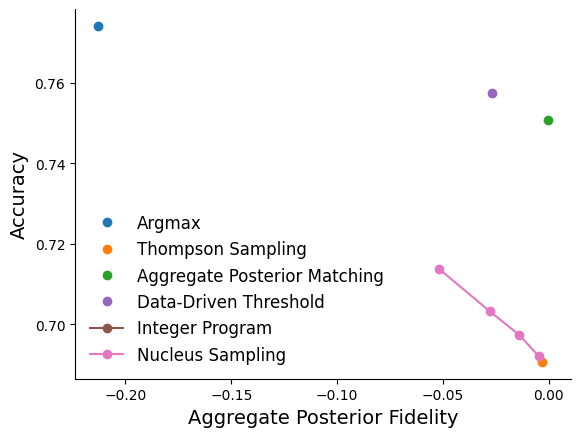

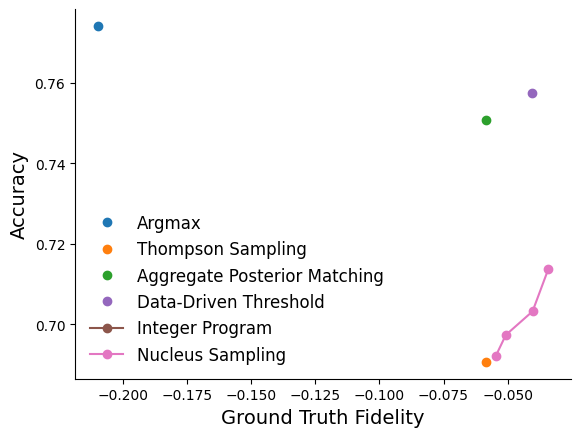

In [18]:
pareto_points = (
    "Argmax",
    "Thompson Sampling",
    "Aggregate Posterior Matching",
    "Data-Driven Threshold",
)
pareto_curves = ["Integer Program", "Nucleus Sampling"]

plot_pareto(
    means,
    points=pareto_points,
    curves=pareto_curves,
    fid_col="Aggregate Posterior Fidelity",
    acc_col="Accuracy",
    palette=method_palette,
    filename=f"{plots_dir}pareto_apfidelity.pdf" if save else None,
)
plot_pareto(
    means,
    points=pareto_points,
    curves=pareto_curves,
    fid_col="Ground Truth Fidelity",
    acc_col="Accuracy",
    palette=method_palette,
    filename=f"{plots_dir}pareto_gtfidelity.pdf" if save else None,
)

['Argmax', 'Aggregate Posterior Matching', 'Data-Driven Threshold']
['Thompson Sampling', 'Top-2 Nucleus Sampling', 'Top-3 Nucleus Sampling', 'Top-4 Nucleus Sampling', 'Top-5 Nucleus Sampling']


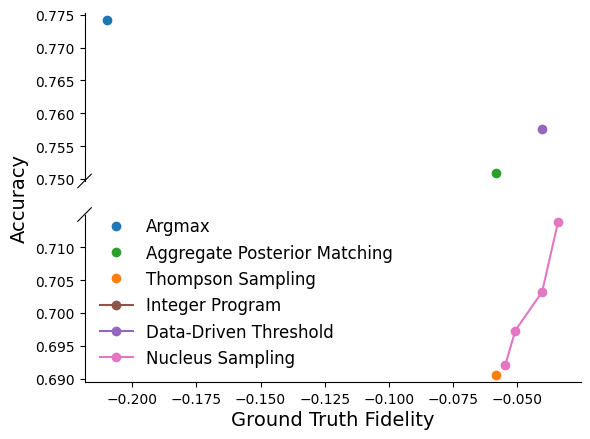

In [19]:
curves_list = [
    ["Integer Program", "Data-Driven Threshold"],
    [
        "Nucleus Sampling",
    ],
]
points_list = [["Argmax", "Aggregate Posterior Matching"], ["Thompson Sampling"]]

plot_broken_pareto(
    means,
    legend="lower left",
    points=points_list,
    curves=curves_list,
    fid_col="Ground Truth Fidelity",
    acc_col="Accuracy",
    breakwidth=0.2,
    palette=method_palette,
    filename=f"{plots_dir}pareto_gtfidelity_broken.pdf",
)

### Bias

/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vect

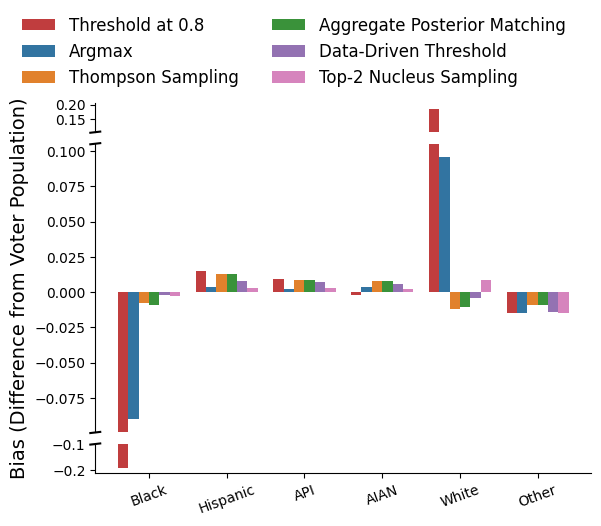

In [20]:
bias_methods = [
    "Threshold at 0.8",
    "Argmax",
    "Thompson Sampling",
    "Aggregate Posterior Matching",
    "Data-Driven Threshold",
    # "Integer Program, $\gamma = 0.9$",
    "Top-2 Nucleus Sampling",
]

broken_axis_biasplot(
    fractional_bias[bias_methods],
    annotations=False,
    bar_order=display_order,
    palette=method_palette,
    filename=f"{plots_dir}fracbias.pdf",
)

### Maps

In [21]:
region_unit = "county"
map_col = "county"
min_population = 10  ## cut off small ouliers

reference = "ap"

condition_columns = [map_col]

cleaned = clean_data(state_voter_file, prob_cols, condition_cols=condition_columns)
cleaned = cleaned.reindex(predictions.index)
labels = cleaned["true"]
probs = cleaned[prob_cols]

In [22]:
grouped_probs = cleaned[prob_cols + [map_col]]
preds = predictions
preds[map_col] = cleaned[map_col]

pop_by_region = preds.groupby(map_col).agg(lambda x: (x != UNCODED_VAL).sum())
white_pop_by_region = preds.groupby(map_col).agg(lambda x: (x == WHITE_VAL).sum())
white_frac_by_region = white_pop_by_region / pop_by_region

if reference == "ap":
    ref_frac_by_region = grouped_probs.groupby(map_col).mean()[
        prob_cols[WHITE_VAL]
    ]  # agg(lambda x: (x == 2).mean())
elif reference == "gt":
    ref_frac_by_region = white_frac_by_region["true"]
else:
    raise ValueError()

minimum_mask = pop_by_region < min_population
diff_by_region = (
    white_frac_by_region - np.array(ref_frac_by_region)[:, np.newaxis]
)  # np.array(white_frac_by_zip["true"])[:, np.newaxis]
diff_by_region["True Caucasian Population"] = ref_frac_by_region
diff_by_region[minimum_mask] = 0
diff_by_region = diff_by_region.reset_index()
diff_by_region

Method,county,true,Argmax,Thompson Sampling,Threshold at 0.5,Threshold at 0.55,Threshold at 0.6,Threshold at 0.65,Threshold at 0.7,Threshold at 0.75,...,Threshold at 0.95,Threshold at 1.0,Top-2 Nucleus Sampling,Top-3 Nucleus Sampling,Top-4 Nucleus Sampling,Top-5 Nucleus Sampling,Aggregate Posterior Matching,True Population Matching,Data-Driven Threshold,True Caucasian Population
0,alamance,0.021469,0.196421,-0.008227,0.197974,0.210148,0.210505,0.210681,0.207098,0.192776,...,0.249648,0.0,0.040837,0.015659,0.005975,0.008558,0.093774,0.100875,0.100230,0.726110
1,alexander,0.012441,0.059704,-0.019898,0.059704,0.059592,0.061992,0.061992,0.069434,0.076977,...,0.082092,0.0,0.014928,0.019903,0.004978,-0.004972,0.052242,0.054729,0.052242,0.917908
2,alleghany,0.030128,0.030128,-0.013732,0.030128,0.030128,0.030128,0.030128,0.030128,0.030128,...,0.047671,0.0,0.021356,-0.013732,-0.013732,-0.013732,0.030128,0.030128,0.030128,0.952329
3,anson,-0.002417,-0.060030,-0.018877,-0.045164,0.022925,0.066021,0.099065,0.050493,0.095732,...,0.395732,0.0,0.034620,-0.039454,-0.002417,0.022275,-0.199947,-0.195832,-0.187602,0.520935
4,ashe,0.007638,0.014487,-0.002636,0.014487,0.014487,0.014487,0.014487,0.014487,0.014487,...,0.035035,0.0,0.011062,0.011062,0.000788,-0.023184,0.014487,0.014487,0.014487,0.964965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,wayne,0.057148,0.142176,-0.002002,0.147121,0.191117,0.211670,0.210208,0.200326,0.194776,...,0.315367,0.0,0.011862,-0.004774,-0.004774,0.006316,-0.070394,-0.070394,-0.059303,0.595347
96,wilkes,0.011246,0.045423,-0.006475,0.045423,0.046657,0.046657,0.046657,0.047897,0.050396,...,0.059347,0.0,0.007449,0.002385,0.017575,0.008714,0.042892,0.044158,0.042892,0.940653
97,wilson,0.021917,0.029077,-0.001950,0.034051,0.041231,0.082215,0.107261,0.106750,0.162528,...,0.342044,0.0,-0.004336,0.023110,-0.004336,-0.001950,-0.191687,-0.185720,-0.188107,0.524623
98,yadkin,0.010573,0.047126,-0.005093,0.047126,0.047126,0.047126,0.047126,0.047126,0.047126,...,0.057570,0.0,0.015794,0.000129,0.002740,0.005351,0.047126,0.047126,0.047126,0.942430


In [23]:
match region_unit:
    case "county":
        map_col = "county"
        state_colname = "STUSPS"
        unit_colname = "NAME"  # "NAMELSAD"
        shapes = geopandas.read_file(SHAPEFILE)  # usa-states-census-2014.shp')
    case _:
        raise ValueError()

shapes = shapes[shapes[state_colname] == state]
shapes[unit_colname] = shapes[unit_colname].str.lower()
diff_by_region[map_col] = diff_by_region[map_col].str.lower()
merged = pd.merge(
    shapes, diff_by_region, left_on=unit_colname, right_on=map_col, how="inner"
)

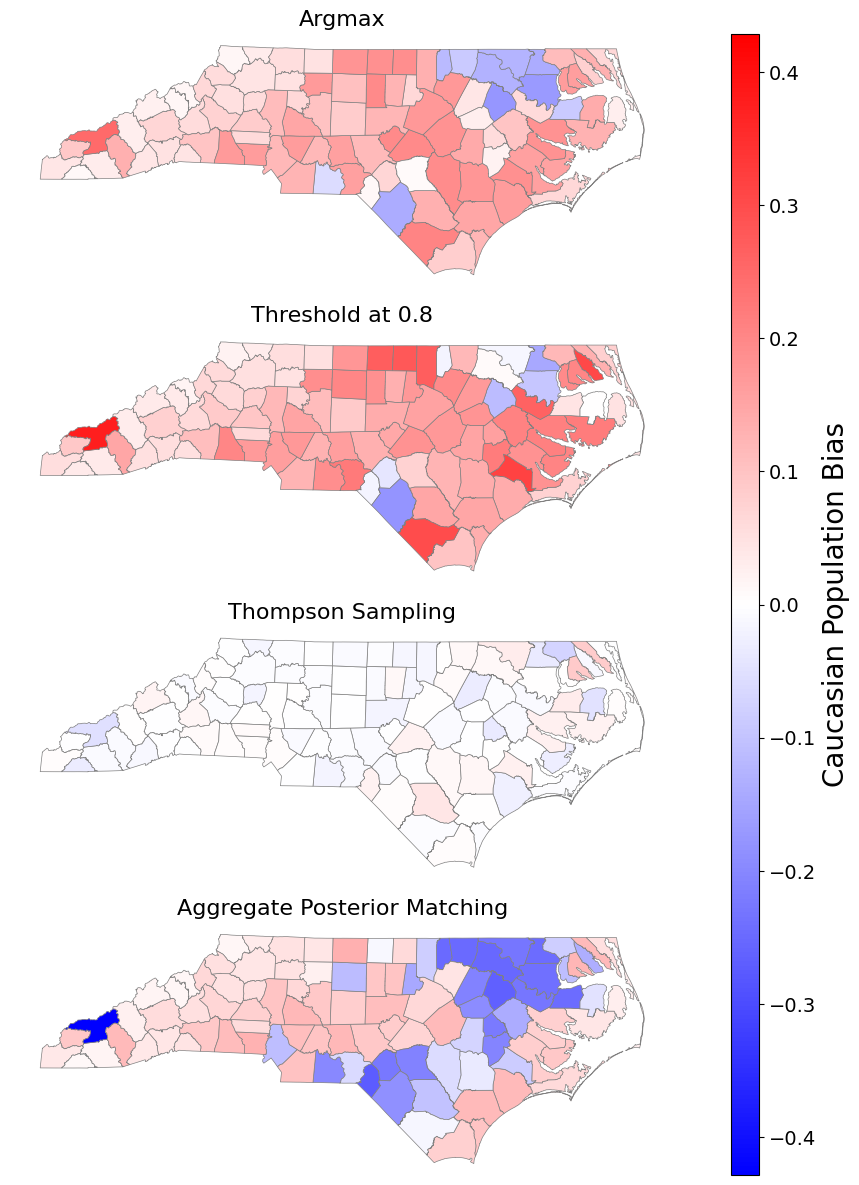

In [24]:
biasmap_plot_path = f"{plots_dir}biasmap_{reference}.pdf" if save else None

draw_bias_map(
    merged,
    [
        "Argmax",
        "Threshold at 0.8",
        "Thompson Sampling",
        "Aggregate Posterior Matching",
    ],
    filename=biasmap_plot_path,
)

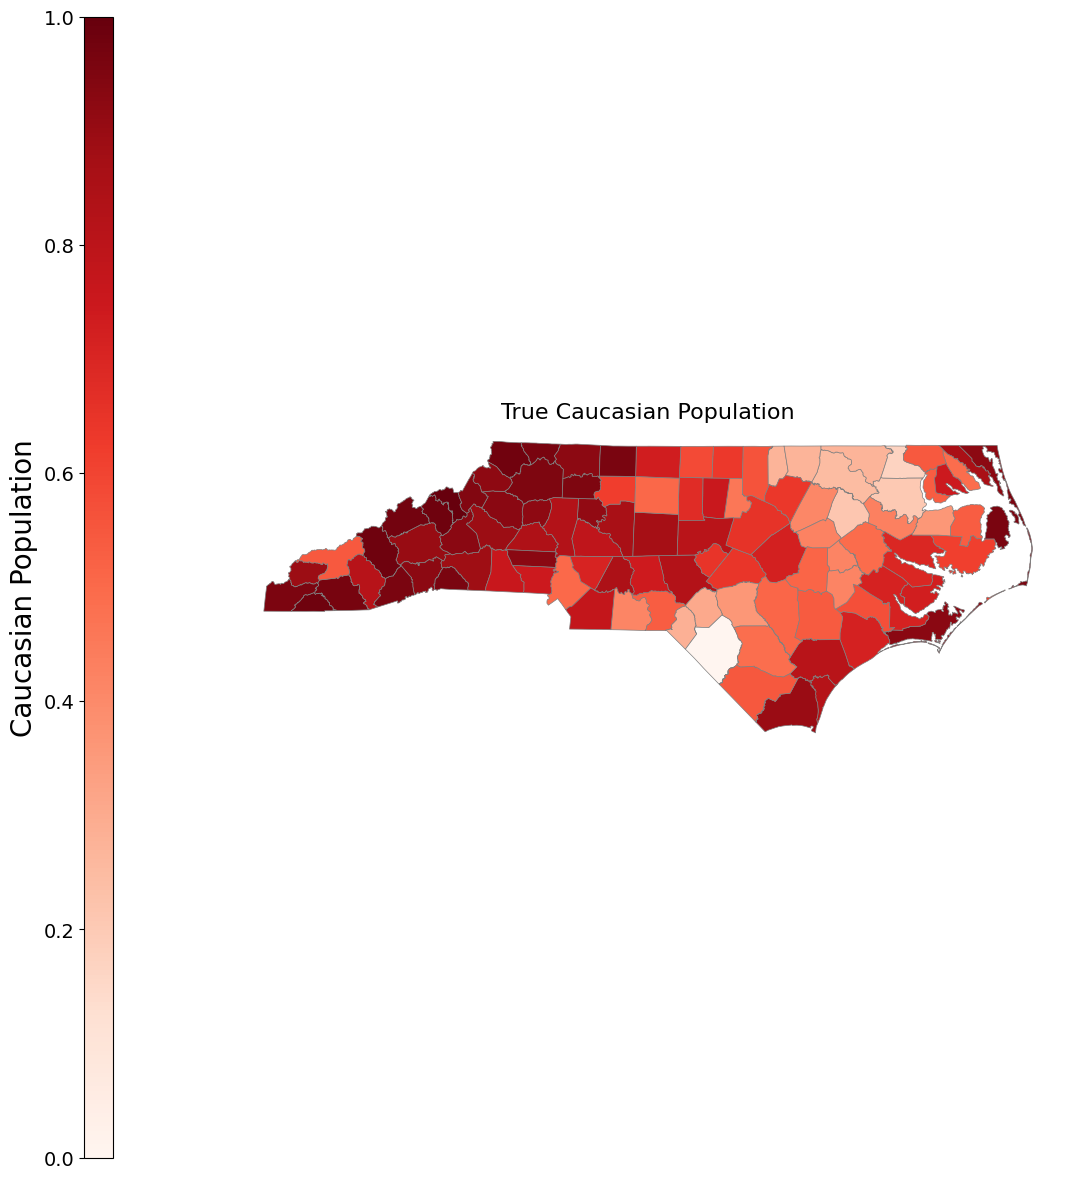

In [25]:
pop_map_plot_path = f"{plots_dir}popmap_{reference}.pdf" if save else None
draw_pop_map(merged, "True Caucasian Population", filename=pop_map_plot_path)

### Calibration

In [26]:
cleaned = clean_data(state_voter_file, prob_cols)
labels = cleaned["true"]
probs = cleaned[prob_cols]

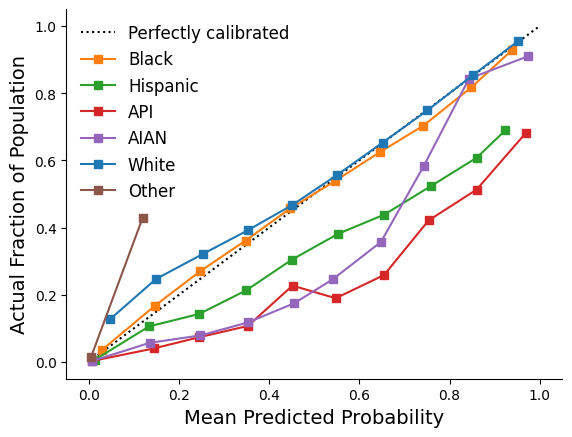

In [27]:
## with sklearn
probs = cleaned[pd.Series(prob_cols)[display_reordering[: len(prob_cols)]]]

calibration_plot_path = f"{plots_dir}calibration.pdf" if save else None

plot_calibration(
    labels.replace({old: new for new, old in enumerate(display_reordering)}),
    probs,
    race_text[display_reordering].reset_index(drop=True),
    palette=race_palette,
    filepath=calibration_plot_path,
)